In [1]:
# import libraries
import os
import json
import numpy as np
from itertools import combinations

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from skopt import BayesSearchCV

import cv2
from matplotlib import pyplot as plt

In [2]:
# Load JSON files
with open(os.path.abspath('./hdr_data/labels.json'), 'r') as f:
    scenes = json.load(f)

with open(os.path.abspath('./hdr_data/histograms.json'), 'r') as f:
    histograms = json.load(f)

# Create a dictionary to match scenes to histograms
scene_histograms = {}
for item in histograms:
    scene_name = item['scene']
    if scene_name not in scene_histograms:
        scene_histograms[scene_name] = []
    scene_histograms[scene_name].append({'image': item['image'], 'histogram': item['histogram']})

data = []
exposure_threshold = 100000  # 100 ms in microseconds

for scene in scenes:
    scene_name = scene['scene']
    best_exposures = scene['best_exposure_times']

    if scene_name in scene_histograms:
        hist_data = scene_histograms[scene_name]
        available_images = []

        # Filter images based on exposure time
        for image_entry in hist_data:
            image_name = image_entry['image']
            exposure_time = float(image_name.split('.')[0])  # Extract exposure time
            histogram = image_entry['histogram']

            if exposure_time < exposure_threshold:
                available_images.append((np.array(histogram).flatten(), exposure_time))

        # Create combinations of two images for input
        for hist_1, hist_2 in combinations(available_images, 2):
            histogram_1, exposure_1 = hist_1
            histogram_2, exposure_2 = hist_2

            # Combine inputs
            input_data = np.concatenate([histogram_1, histogram_2, [exposure_1], [exposure_2]])
            output_data = np.array(best_exposures)

            data.append((input_data, output_data))

# Convert to NumPy arrays for training
inputs = np.array([item[0] for item in data])
outputs = np.array([item[1] for item in data])

# Print the shapes of the inputs and outputs to verify
print(f'Inputs shape: {inputs.shape}')
print(f'Outputs shape: {outputs.shape}')


Inputs shape: (2655, 514)
Outputs shape: (2655, 3)


In [3]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

# Create a RandomForestRegressor instance
rf = RandomForestRegressor(random_state=1)

# Perform Randomized Search to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=2, n_jobs=-1, verbose=3, scoring='neg_mean_absolute_error', random_state=1)
random_search.fit(X_train, y_train)

# Get the best estimator from random search
best_rf = random_search.best_estimator_

# Train the best Random Forest model
best_rf.fit(X_train, y_train)

param_grid = {
    'n_estimators': list(range(10, 300, 10)),
    'max_depth': list(range(5, 50, 5)),
    'min_samples_split': list(range(2, 10)),
    'min_samples_leaf': list(range(1, 5)),
    'max_features': ['log2', 'sqrt']
}

# Perform Bayesian Optimization to further improve hyperparameters
bayes_search = BayesSearchCV(estimator=best_rf, search_spaces=param_grid, n_iter=30, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=1)
bayes_search.fit(X_train, y_train)

# Get the best estimator from Bayesian search
best_rf_bayes = bayes_search.best_estimator_

# Train the best Random Forest model from Bayesian Optimization
best_rf_bayes.fit(X_train, y_train)

# Validate the model
y_pred = best_rf_bayes.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Validation Mean Absolute Error: {mae}")
print(f"Validation R^2 Score: {r2}")

# Print the best parameters found by Random Search
print("Best Random Hyperparameters:", random_search.best_params_)
print("Best Bayes Hyperparameters:", bayes_search.best_params_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Validation Mean Absolute Error: 19441.971843787625
Validation R^2 Score: 0.9309927565833758
Best Random Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
Best Bayes Hyperparameters: OrderedDict([('max_depth', 45), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 220)])


In [4]:
import random

# Select a specific scene and get available inputs for that scene
scene_name = 'scene_0011'  # Replace with the specific scene you want to test

# Get the histogram data for the specified scene
if scene_name not in scene_histograms:
    print(f'No available histograms found for scene {scene_name}')
else:
    # Get all histograms for the specified scene
    hist_data = [d for d in scene_histograms[scene_name] if int(d['image'].split('.')[0]) <= 100000]

    # Check if there are enough histograms available for pairing
    if len(hist_data) < 2:
        print(f'Not enough histograms available for scene {scene_name} to create input pairs')
    else:
        # Select two random histograms from the scene
        hist_1, hist_2 = sorted(random.sample(hist_data, 2), key=lambda x: float(x['image'].split('.')[0]))

        # Extract histogram and exposure time from each selected entry
        histogram_1, exposure_1 = np.array(hist_1['histogram']).flatten(), float(hist_1['image'].split('.')[0])
        histogram_2, exposure_2 = np.array(hist_2['histogram']).flatten(), float(hist_2['image'].split('.')[0])

        # Combine histograms and exposure times to create input data
        random_input = np.concatenate([histogram_1, histogram_2, [exposure_1], [exposure_2]])

        # Reshape the input to match the model's expected input shape
        random_input = np.array(random_input).reshape(1, -1)

        # Make a prediction
        predicted_exposures = best_rf_bayes.predict(random_input)

        # Get the ground-truth exposure times for the scene
        ground_truth_exposures = next(scene['best_exposure_times'] for scene in scenes if scene['scene'] == scene_name)

        # Calculate the percentage error for each exposure time
        percentage_errors = [
            abs((pred - gt) / gt) * 100 if gt != 0 else 0
            for pred, gt in zip(predicted_exposures[0], ground_truth_exposures)
        ]

        # Print the predicted and ground-truth exposure times along with percentage errors
        print(f'Input exposure times: {random_input[0, -2:]}')
        print(f'Predicted exposure times for scene {scene_name}: {predicted_exposures}')
        print(f'Ground-truth exposure times for scene {scene_name}: {ground_truth_exposures}')
        print(f'Percentage errors for each exposure time: {percentage_errors}')


Input exposure times: [12000. 48000.]
Predicted exposure times for scene scene_0011: [[ 187.         1500.         6054.54545455]]
Ground-truth exposure times for scene scene_0011: [187.0, 1500.0, 6000.0]
Percentage errors for each exposure time: [0.0, 0.0, 0.9090909090909159]


Using nearest exposure times for predicted image: [187, 1500, 6000]


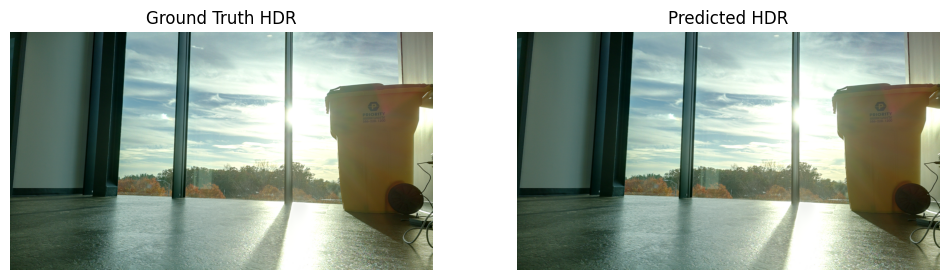

In [5]:
# Load images for ground-truth exposures
gt_images = []
for exposure in ground_truth_exposures:
    image_path = os.path.join('./hdr_data/', scene_name, f'{int(exposure)}.png')
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        gt_images.append(img)

# Merge ground-truth HDR images
if gt_images:
    merge_mertens = cv2.createMergeMertens()
    hdr_gt = merge_mertens.process(gt_images)
    hdr_gt = np.clip(hdr_gt * 255, 0, 255).astype('uint8')

# Load images for predicted exposures
predicted_images = []
available_images = [f for f in os.listdir(os.path.join('./hdr_data/', scene_name)) if f.endswith('.png')]
available_exposures = [int(os.path.splitext(f)[0]) for f in available_images]

closest_exposures = []
for exposure in predicted_exposures[0]:
    # Find the closest available exposure
    closest_exposure = min(available_exposures, key=lambda x: abs(x - exposure))
    image_path = os.path.join('./hdr_data/', scene_name, f'{closest_exposure}.png')
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        predicted_images.append(img)
        closest_exposures.append(closest_exposure)
print(f"Using nearest exposure times for predicted image: {closest_exposures}")

# Merge predicted HDR images
if predicted_images:
    hdr_pred = merge_mertens.process(predicted_images)
    hdr_pred = np.clip(hdr_pred * 255, 0, 255).astype('uint8')
    
# Display the HDR images side by side
if gt_images and predicted_images:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(hdr_gt, cv2.COLOR_BGR2RGB))
    plt.title('Ground Truth HDR')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(hdr_pred, cv2.COLOR_BGR2RGB))
    plt.title('Predicted HDR')
    plt.axis('off')

    plt.show()
